In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import time
import tqdm
import math
import scipy
import cv2
import json

In [3]:
def get_frames_as_torch(f, start, end):
    start_index = f["frame_start_indexes"][start]
    end_index = f["frame_start_indexes"][end]

    frame_keys_np = f["frame_keys"][start_index:end_index]
    frame_values = f["frame_values"][start_index:end_index]

    num_elements = len(frame_keys_np)
    num_fields = len(frame_keys_np.dtype.names)
    new_shape = (num_elements, num_fields)


    # convert compound type to int32 array
    frame_keys = np.zeros(new_shape, dtype=np.int32)
    for i, name in enumerate(frame_keys_np.dtype.names):
        frame_keys[:, i] = frame_keys_np[name].astype(np.int32)

    frame_keys = frame_keys.astype(np.int32)
    frame_values = frame_values.astype(np.int32)

    frame_keys = torch.from_numpy(frame_keys)
    sp = torch.sparse_coo_tensor(frame_keys.T, frame_values, size=(end - start, 2, 1280, 720))
    return sp


def sparse_to_video(frames, start, count):
    f = []
    for i in tqdm.trange(count):
        f.append(frames[i + start].to_dense())
    f = torch.stack(f) * 255
    zeros = torch.zeros(len(f), 1, *f.shape[2:])
    return torch.concat([f, zeros], dim=1).permute(0, 3, 2, 1)

def draw_polygon(points, pose):
    (px, py, x, y, z, qw, qx, qy, qz) = pose

    object_q = scipy.spatial.transform.Rotation.from_quat([
        qx,
        qy,
        qz,
        qw
    ])
    points = object_q.apply(points)
    points += np.array([x, y, z])
    pixels = positions_to_pixels(points)
    return pixels

# just rotating in the middle and shifting pixels does not work
def draw_polygon2(points, pose):
    (px, py, x, y, z, qw, qx, qy, qz) = pose

    object_q = scipy.spatial.transform.Rotation.from_quat([
        qx,
        qy,
        qz,
        qw
    ])
    points = object_q.apply(points)
    points += np.array([0, 0, z])
    pixels = positions_to_pixels(points)
    pixels += np.array([px - 650.172869, py - 285.398327])
    return pixels

def positions_to_pixels(positions):
    camera_matrix = np.array([
        [1700.74372, 0, 650.172869],
        [0, 1700.74372, 285.398327],
        [0, 0, 1]
    ])
    positions[:, 1:3] = -positions[:, 1:3]
    vec = np.array([0, 0, 0], dtype=np.float32)
    distortion_coeff = np.array([0, 0, 0, 0, 0], dtype=np.float32)
    pixels, _  = cv2.projectPoints(positions, vec, vec, camera_matrix, distortion_coeff)
    return pixels

def draw_frame(frame, pose, polygon):
    f, a = plt.subplots(1, 1, figsize=(12, 7))
    a.imshow(frame)
    plt.scatter([pose[0]], [pose[1]], marker="+", color="white")
    center = draw_polygon([[0,0,0]], pose).reshape(-1, 2)
    plt.scatter([center[0,0]], [center[0,1]], marker="x", color="red")
    pixels = draw_polygon(polygon, pose).reshape(-1, 2)
    plt_polygon = plt.Polygon(pixels, color="#ffffff50")
    a.add_patch(plt_polygon)
    plt.show()


In [4]:
def render_mask_and_bbox(pose, polygon, size=np.array((1280, 720))):
    f = plt.figure(figsize=size / 100, dpi=100)
    f.add_axes([0,0,1,1])
    f.gca().axis("off")
    bg = np.zeros(size).T
    f.gca().imshow(bg, cmap="gray")
    canvas = f.canvas
    pixels = draw_polygon(polygon, pose).reshape(-1, 2)
    plt_polygon = plt.Polygon(pixels, color="#ff0")
    f.gca().add_patch(plt_polygon)
    canvas.draw()
    array = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8).reshape(tuple(size[::-1]) + (4,))[:,:,0].T > 0
    plt.close()
    bbox = plt_polygon.get_extents()
    return array, np.array([bbox.x0, bbox.y0, bbox.x1, bbox.y1])

In [5]:
import contextlib
import dataclasses
from typing import Callable

@dataclasses.dataclass
class EventRecording():

    file: str
    resolution = np.array([1280, 720])

    @property
    def frame_indices(self):
        return self.fp["frame_start_indexes"]
    
    @property
    def frames(self):
        return get_frames_as_torch(self.fp, 0, len(self.frame_indices) - 1)

    @property
    def keys(self):
        return self.fp.keys()

    @property
    def poses(self):
        return {p: self.fp[p] for p in self.shapes_present}

    @property
    def shapes_present(self):
        shapes = []
        keys = []
        for p in POLYGONS.keys():
            if p in self.keys:
                shapes.append(p)
        return shapes

    def __enter__(self):
        self.fp = h5py.File(self.file)
        return self

    def __exit__(self, *exc):
        self.fp.close()

In [110]:
!find ../basic_shapes -name "*.h5"

../basic_shapes/triangle/shear/2024_02_04_21_41_21_triagle_none_shear_left_processed/frames.h5
../basic_shapes/triangle/shear/2024_02_04_21_47_02_triagle_none_shear_left_processed/frames.h5
../basic_shapes/triangle/shear/2024_02_04_21_53_21_triagle_none_shear_right_processed/frames.h5
../basic_shapes/triangle/shear/2024_02_04_21_56_01_triagle_none_shear_right_processed/frames.h5
../basic_shapes/triangle/rotation/2024_02_04_20_18_40_triagle_none_rot_left_processed/frames.h5
../basic_shapes/triangle/rotation/2024_02_04_20_21_45_triagle_none_rot_left_processed/frames.h5
../basic_shapes/triangle/rotation/2024_02_04_20_26_56_triagle_none_rot_right_processed/frames.h5
../basic_shapes/triangle/rotation/2024_02_04_20_30_29_triagle_none_rot_right_processed/frames.h5
../basic_shapes/triangle/affine/2024_02_04_21_13_14_triagle_none_affine_right_processed/frames.h5
../basic_shapes/triangle/affine/2024_02_04_21_33_52_triagle_none_affine_left_processed/frames.h5
../basic_shapes/triangle/affine/2024_

In [124]:
!ls ../basic_shapes/square/translation/2024_03_04_15_59_57_square_none_trans_right_processed/ -alh

total 4,2G
drwxrwxr-x 2 jens jens 4,0K jun 24 00:51 .
drwxrwxr-x 6 jens jens 4,0K jun 23 03:25 ..
-rw-rw-r-- 1 jens jens 1,5G jun 23 23:23 events.aedat4
-rw-rw-r-- 1 jens jens 2,7G jun 24 00:35 frames.h5
-rw-rw-r-- 1 jens jens 5,6K jun 24 00:51 frames_square.avi
-rw-rw-r-- 1 jens jens  165 jun 23 23:20 metadata.txt
-rw-rw-r-- 1 jens jens  33M jun 23 23:23 positions.json


In [108]:
torch.concat([torch.zeros(10, 10, 2), torch.zeros(10, 10, 1)], dim=2).shape

torch.Size([10, 10, 3])

In [154]:
!find /mnt/raid

bbox.h5        frames.h5	  mask.h5	positions.json
events.aedat4  frames_square.avi  metadata.txt	square.avi


In [153]:
with EventRecording("/mnt/raid0b/debug/basic_shapes/square/translation/2024_03_04_15_59_57_square_none_trans_right_processed/bbox.h5") as rec:
    #fr = rec.frames
    print(rec.fp["square_bbox"])

[383.13242 224.26299 596.78107 438.1121 ]


In [28]:
fr.coalesce().indices()[0]

tensor([     0,      1,      2,  ..., 133490, 133490, 133490])

In [40]:
ps.shape

(133491, 9)

In [159]:
file_rec = "/mnt/raid0b/debug/basic_shapes/blob/translate_scale_rotate/2024_04_18_17_34_12_blob_none_trans_scale_rot_right_processed/mask.h5"

with h5py.File(file_rec, mode="r") as f:
    # sp = get_frames_as_torch(f, 100, 200)
    print(f.keys())
    # plt.imshow(sparse_to_video(sp, 100, 100).sum(0))
    # plt.imshow(arr.T, alpha=0.5)

BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

read 5 000 frames in 0.06 seconds


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1630.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


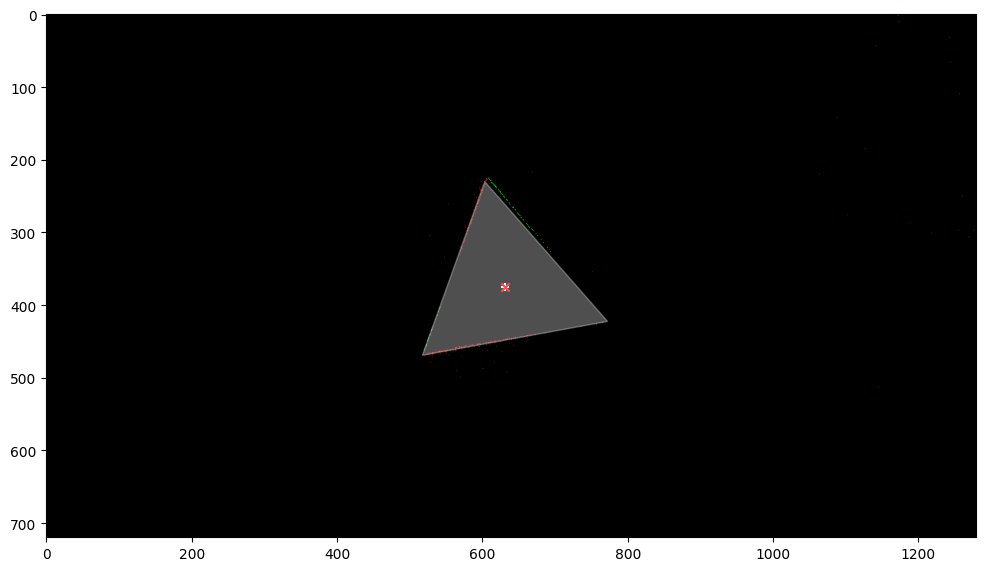

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2706.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


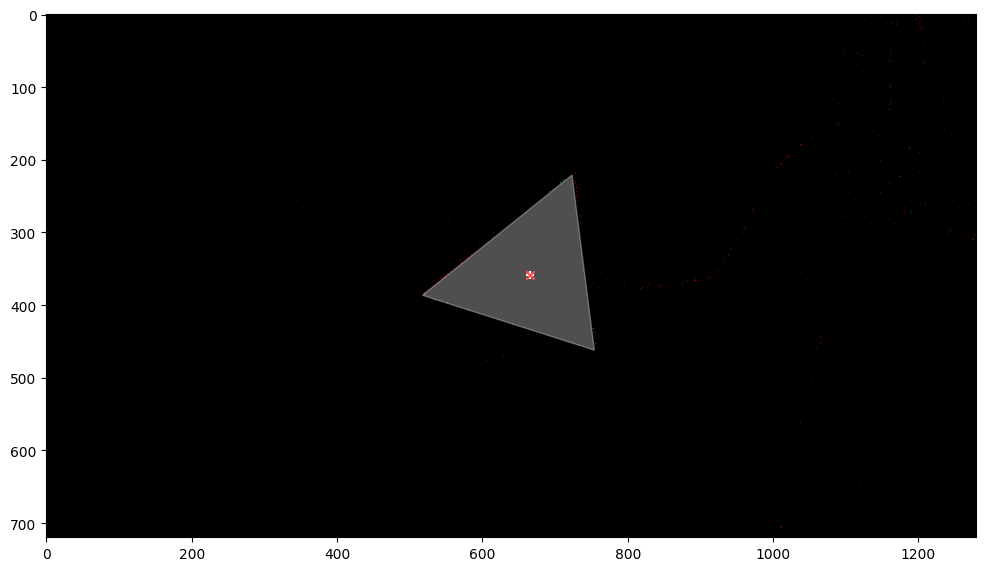

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3017.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


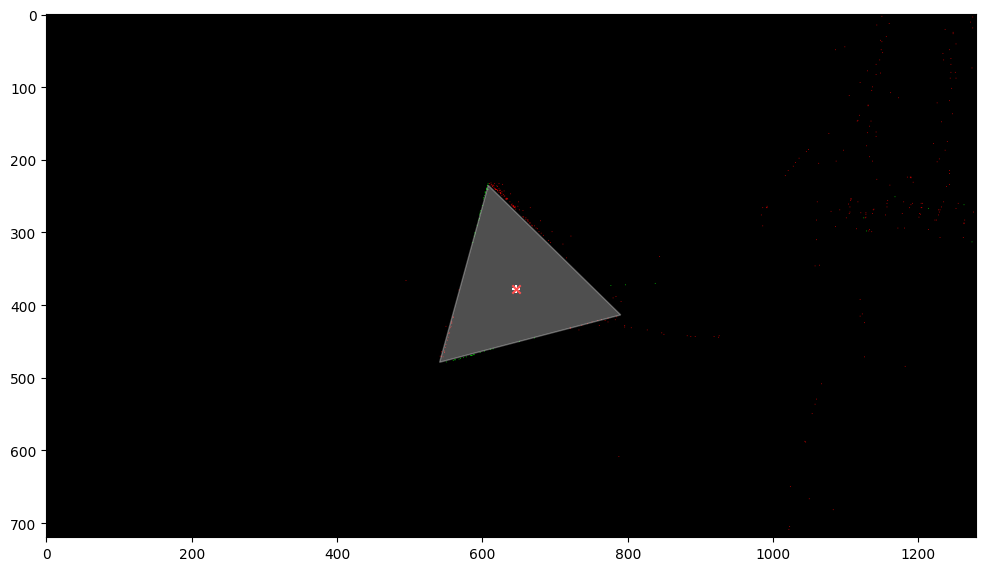

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3323.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


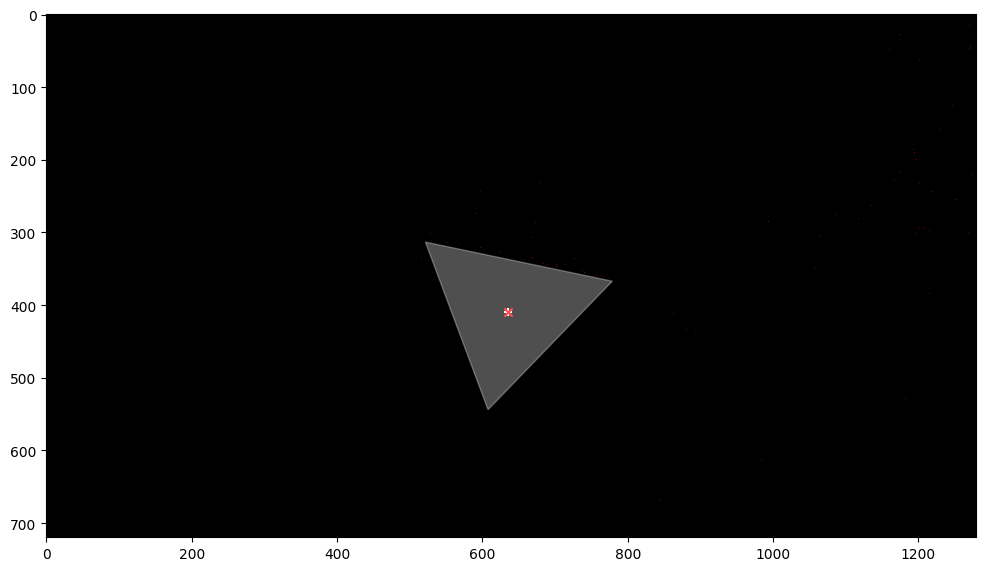

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2955.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


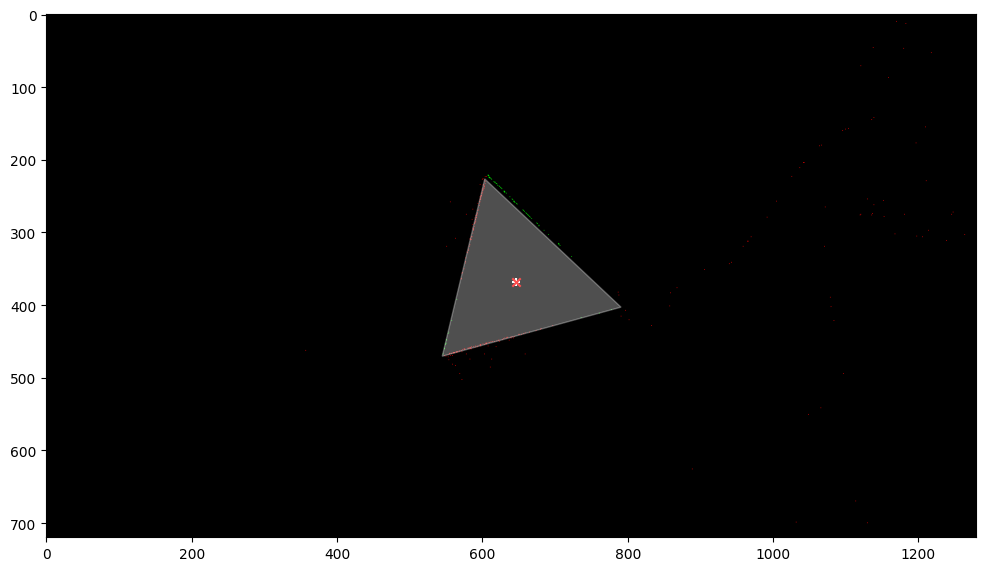

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3151.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


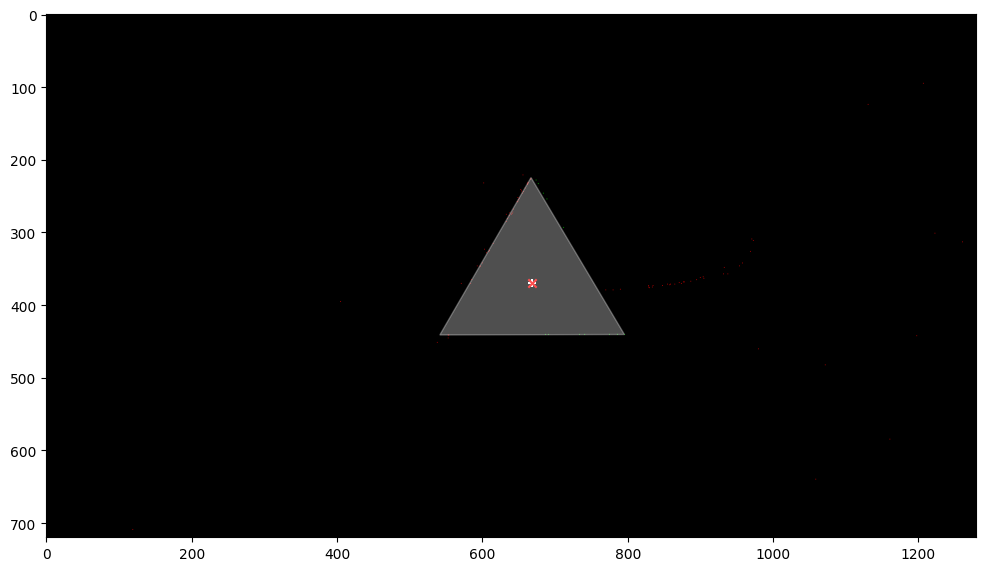

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1994.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


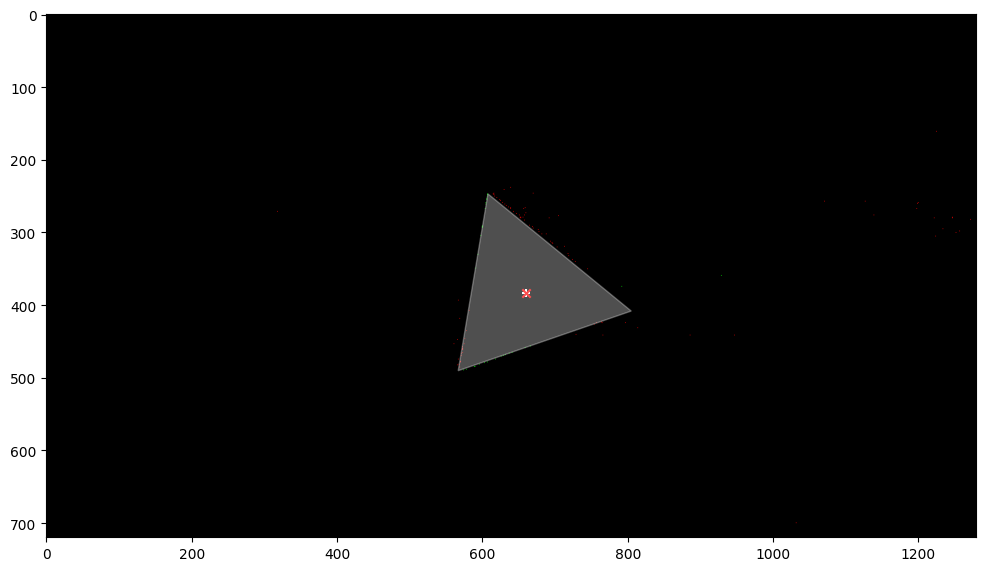

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3039.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


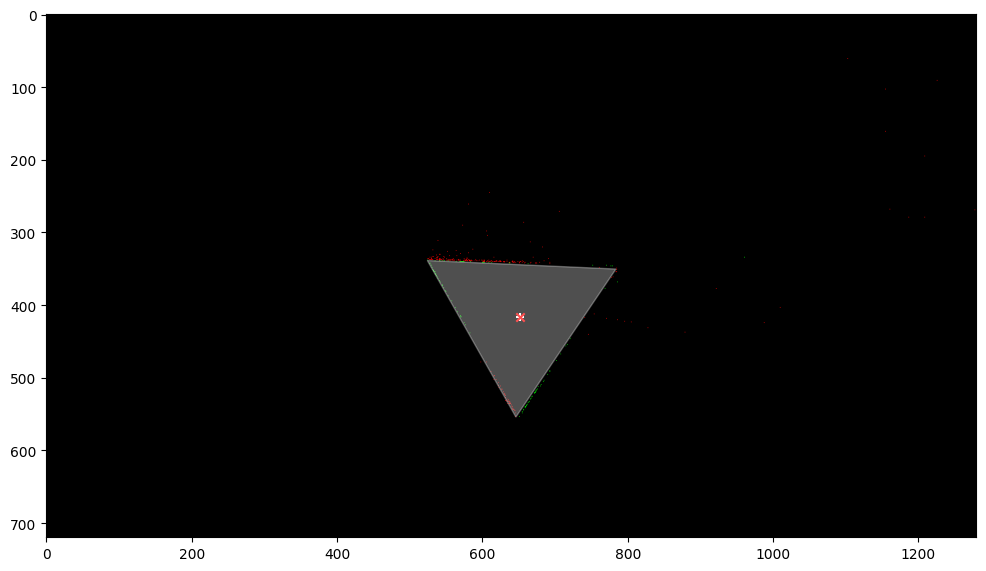

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3043.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


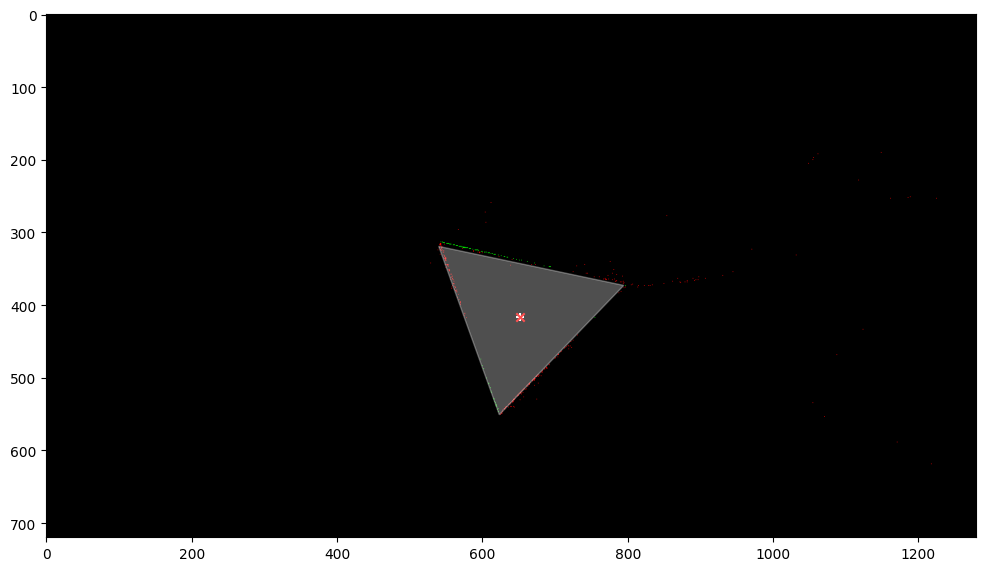

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3323.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


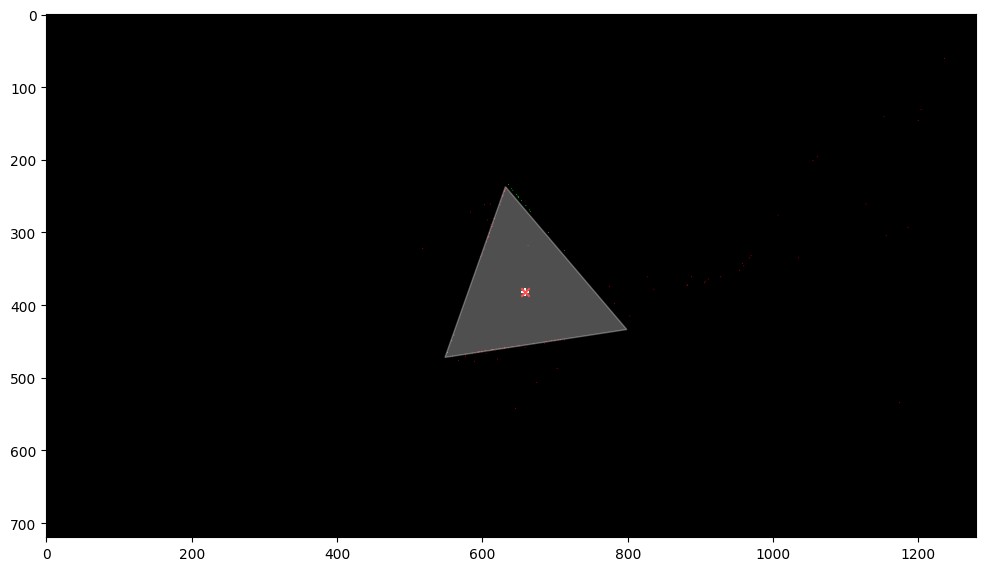

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3339.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


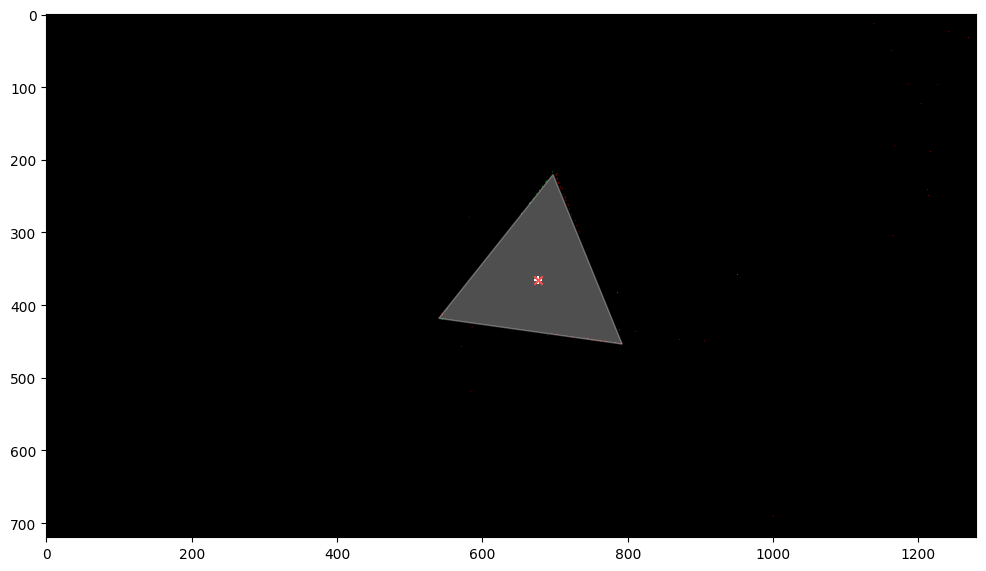

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2381.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


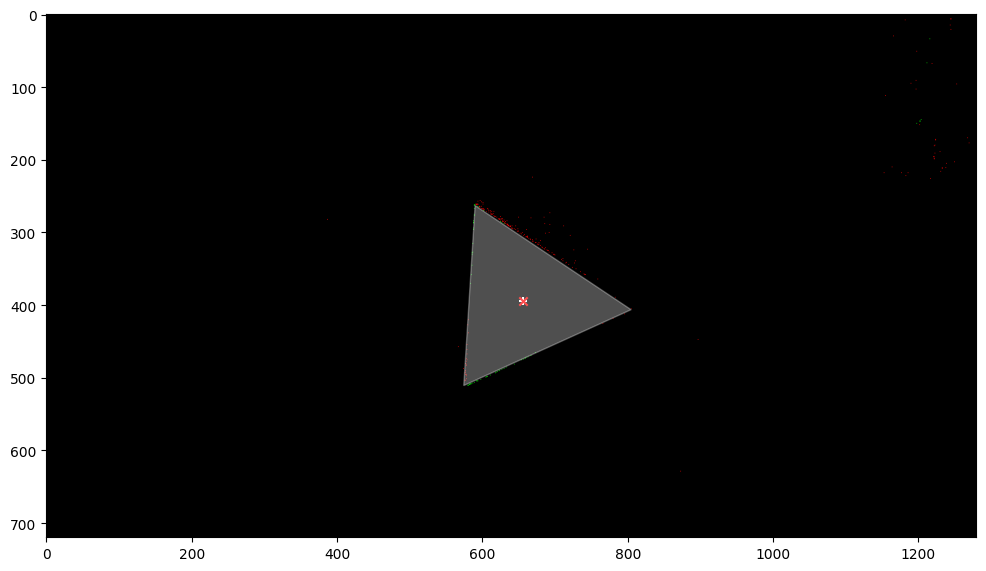

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1818.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


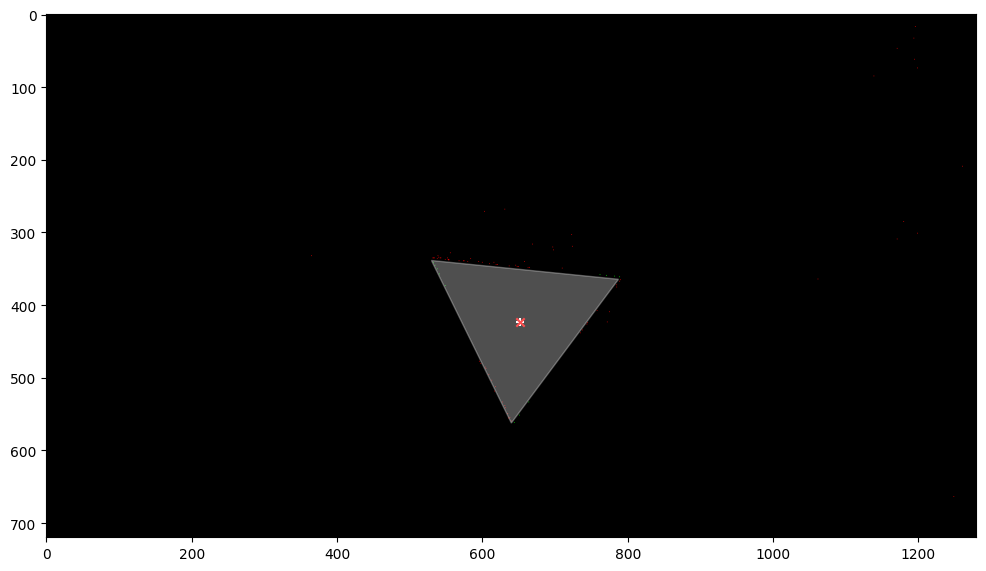

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2504.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


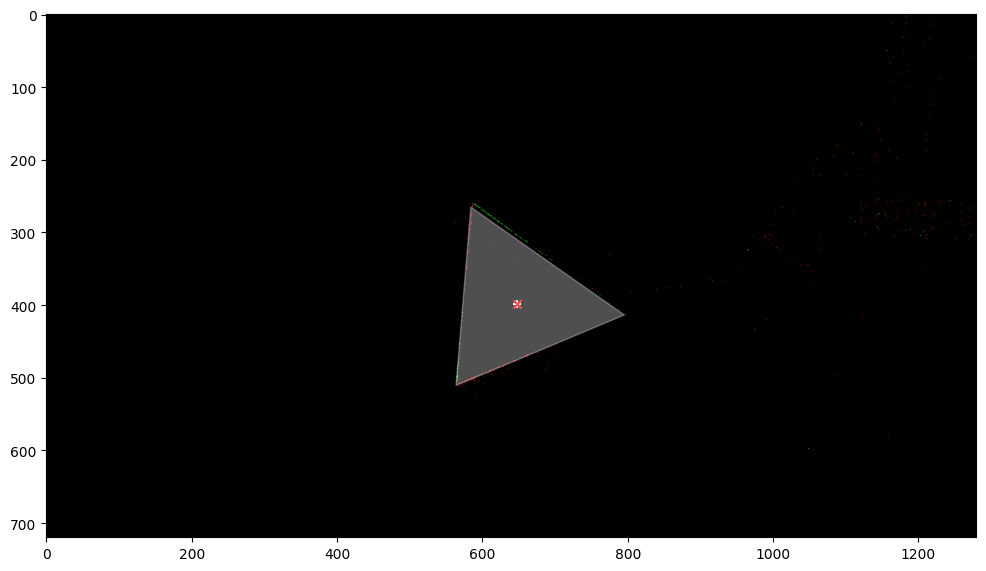

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2303.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


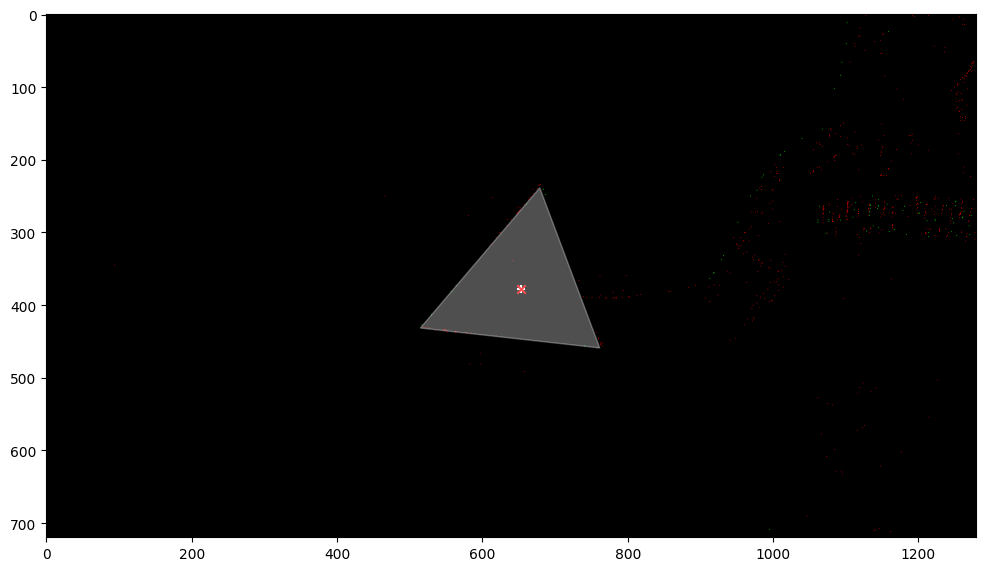

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2853.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


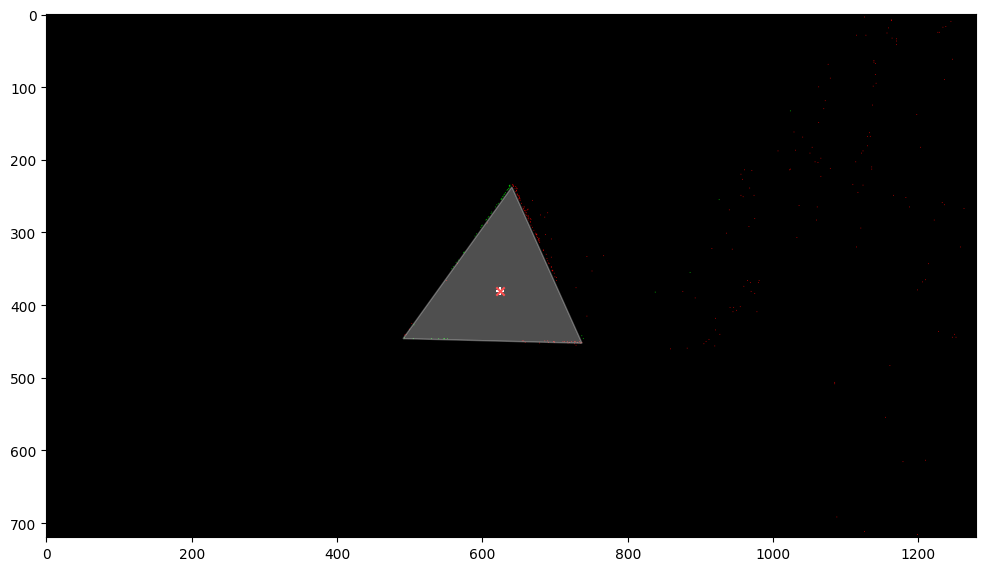

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2826.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


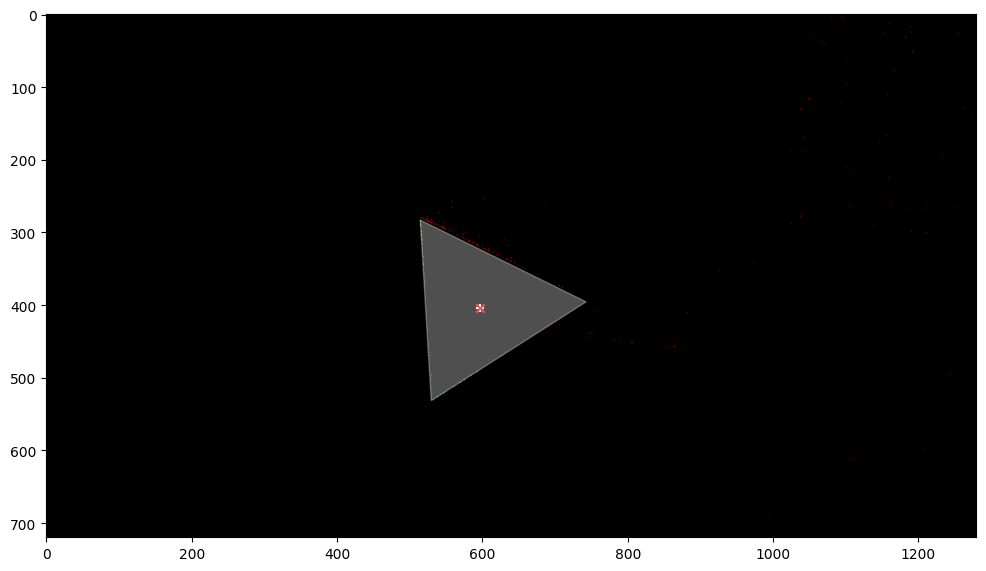

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2447.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


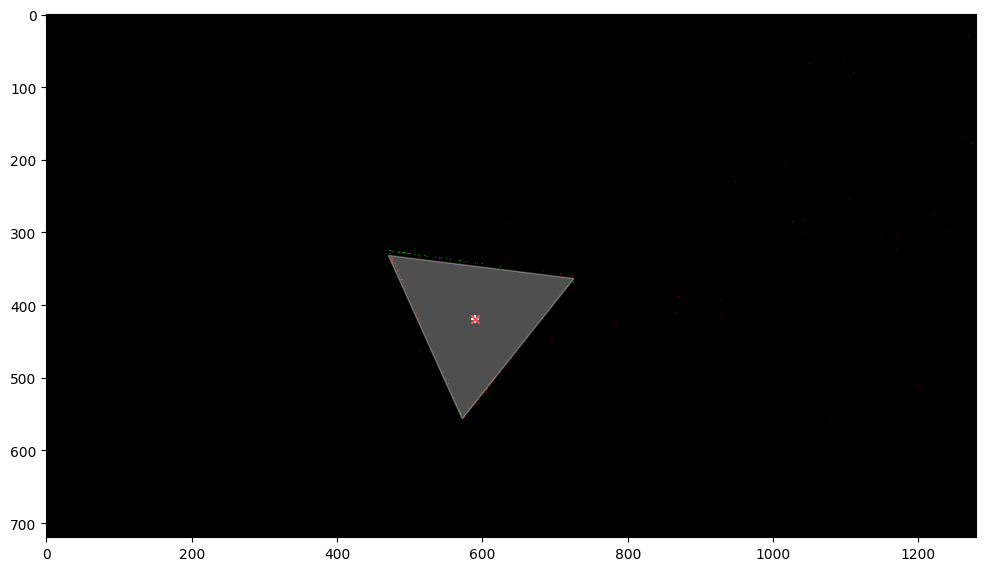

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2741.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


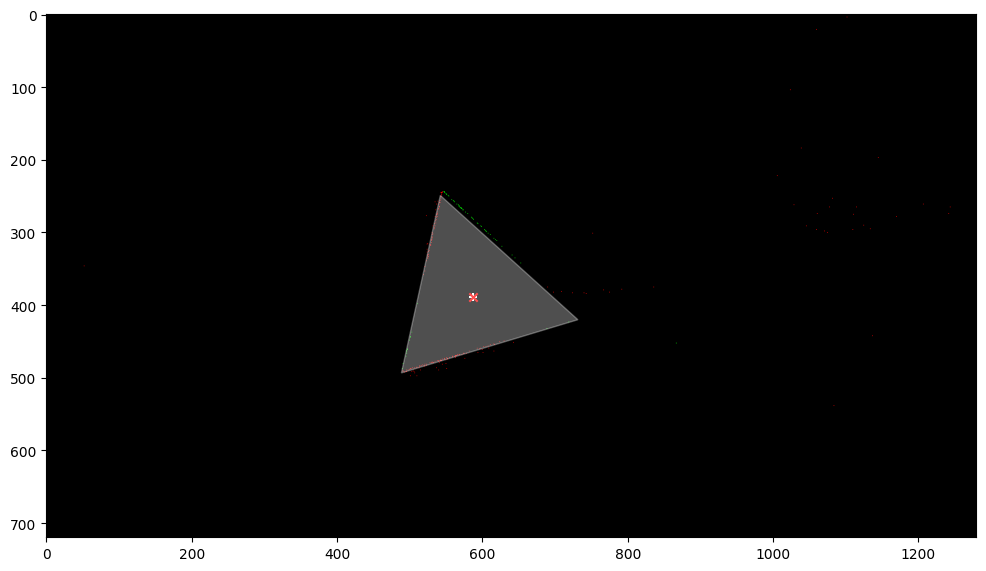

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2444.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


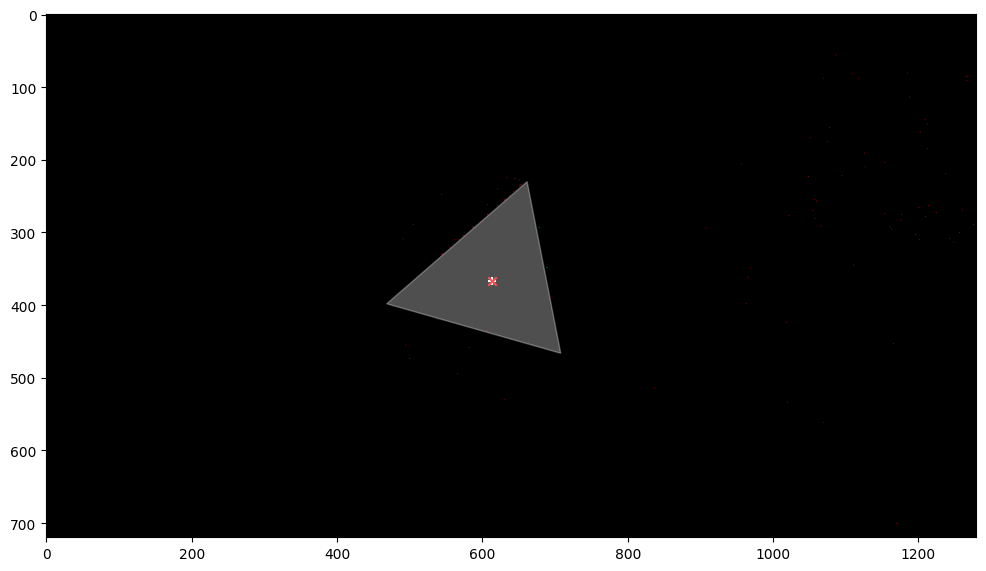

In [4]:
file_rec = "../basic_shapes/triangle/rotation/2024_02_04_20_21_45_triagle_none_rot_left_processed/frames.h5"

with h5py.File(file_rec) as f:
    start = time.time()
    sp = get_frames_as_torch(f, 5000, 10000)
    end = time.time()

    print(f"read 5 000 frames in {end - start:.2f} seconds")

    for i in range(100, 10000, 500):
        sp = get_frames_as_torch(f, i, i + 1)
        video = sparse_to_video(sp, i, 1)
        poses = f["triangle"]
        draw_frame(video[0], poses[i], triangle_polygon)
        plt.show()